In [1]:
import os
import random
import numpy as np
import copy
import easydict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torch.utils.data 

from genotype import *
from torch.autograd import Variable
from torch.autograd import gradcheck

In [2]:
args = easydict.EasyDict({
    "L": 3, #layer 수 
    "M": 20, #모듈갯수
    "N": 5, # 활성화 하는 모듈의 최대 갯수
    "pop" : 64,
    "batch_size" : 128,
    "lr":0.001,
    "neuron_num":20, #모듈의 세부 사항 
    "generation_limit":1000, #학습 횟수
    "readout_num":10, #최종적인 분류 하는 갯수
})

In [3]:
# #data load
transform=transforms.Compose([transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#cifar10
train_cifar_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                                   train=True, 
                                                   transform=transform,
                                                   download=True)
test_cifar_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                                   train=False, 
                                                   transform=transform,
                                                   download=True)
#svhn
train_svhn_dataset = torchvision.datasets.SVHN(root='../../data/',
                                                   split='train', 
                                                   transform=transform,
                                                   download=True)
test_svhn_dataset = torchvision.datasets.SVHN(root='../../data/',
                                                   split='test', 
                                                   transform=transform,
                                                   download=True)

cifar_train_loader = torch.utils.data.DataLoader(train_cifar_dataset,
                                                 batch_size=args.batch_size,
                                                 shuffle = True)
cifar_test_loader = torch.utils.data.DataLoader(test_cifar_dataset,
                                                 batch_size=args.batch_size,
                                                 shuffle = True)

svhn_train_loader = torch.utils.data.DataLoader(train_svhn_dataset,
                                                 batch_size=args.batch_size,
                                                 shuffle = True)
svhn_test_loader = torch.utils.data.DataLoader(test_svhn_dataset,
                                                 batch_size=args.batch_size,
                                                 shuffle = True)


Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ../../data/train_32x32.mat
Using downloaded and verified file: ../../data/test_32x32.mat


In [4]:
#path net model
class Net(nn.Module):

    def __init__(self, args):
        super(Net, self).__init__()
        self.args = args
        self.final_layers = []
        self.init(None)

    def init(self, best_path):
        if best_path is None:
            best_path = [[None] * self.args.M] * self.args.L

        neuron_num = self.args.neuron_num
        module_num = [self.args.M] * self.args.L
        #module_num = self.args.module_num

        """Initialize all parameters"""
        self.fc1 = []
        self.fc2 = []
        self.fc3 = []
        #첫번째 layer
        for i in range(module_num[0]):
            if not i in best_path[0]:
                exec("self.m1" + str(i) + " = nn.Sequential(nn.Conv2d(3,32,3))")
            exec("self.fc1.append(self.m1" + str(i) + ")")
        #두번째 layer
        for i in range(module_num[1]):
            if not i in best_path[1]:
                exec("self.m2" + str(i) + " = nn.Sequential(nn.Conv2d(32,64,3))")
            exec("self.fc2.append(self.m2" + str(i) + ")")
        #세번째 layer
        for i in range(module_num[2]):
            if not i in best_path[2]:
                exec("self.m3" + str(i) + " = nn.Sequential(nn.Conv2d(64,128,3))")
            exec("self.fc3.append(self.m3" + str(i) + ")")

        """final layer which is not inclued in pathnet. Independent for each task"""
        self.final_layers = nn.Linear(512, self.args.readout_num)
        
    def forward(self, x, path):
#         x = x.view(-1, 3*32*32)
        M = self.args.M
        maxpool=nn.MaxPool2d(2,stride=2)
        #for i in range(self.args.L):
        y = F.relu(maxpool(self.fc1[path[0][0]](x)))
        for j in range(1,self.args.N):
            y += F.relu(maxpool(self.fc1[path[0][j]](x)))
        y = y/5
        x = y
        y = F.relu(maxpool(self.fc2[path[1][0]](x)))
        for j in range(1,self.args.N):
            y += F.relu(maxpool(self.fc2[path[1][j]](x)))
        y = y/5
        x = y
        y = F.relu(maxpool(self.fc3[path[2][0]](x)))
        for j in range(1,self.args.N):
            y += F.relu(maxpool(self.fc3[path[2][j]](x)))
        y = y/5
        x = y
        '''
        x = F.relu(self.fc1[path[0][0]](x)) + F.relu(self.fc1[path[0][1]](x)) + F.relu(self.fc1[path[0][2]](x))
        x = F.relu(self.fc2[path[1][0]](x)) + F.relu(self.fc2[path[1][1]](x)) + F.relu(self.fc2[path[1][2]](x))
        x = F.relu(self.fc3[path[2][0]](x)) + F.relu(self.fc3[path[2][1]](x)) + F.relu(self.fc3[path[2][2]](x))
        '''
        x=x.view(x.shape[0],-1)
        x = self.final_layers(x)
        return x

In [5]:
model = Net(args)
gene = Genetic(args.L, args.M, args.N, args.pop)
module_num = [args.M] * args.L
#초기 best path
best_path1 = [[None] * args.M] * args.L
model=model.cuda()

In [6]:
#best path 부분은 학습 안하도록 한다.

#parameter set
trainable_params = []
params_set = [model.fc1, model.fc2, model.fc3]
for path, params in zip(best_path1, params_set):
    for i, param in enumerate(params):
        if  i in path:
            param.requires_grad = False
        else:
            p = {'params': param.parameters()}
            trainable_params.append(p)

p = {'params': model.final_layers.parameters()}
trainable_params.append(p)
optimizer = optim.Adam(trainable_params, lr=args.lr)

In [7]:
#데이터와 경로를 입력으로 받는다.
def train_model(train_loader, path,optimizer):
    fitness = 0.0
    train_len = 0
    total=0
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model.forward(data, path)
        _, pred = torch.max(output.data, 1)       
        train_len += len(target.data)
        fitness += pred.eq(target.data).cpu().sum()
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total += target.size(0)
        correct += (pred == target).sum().item()
#         if not batch_idx < num_batch -1:
#             break
#     fitness = fitness / train_len
    print("loss : {:.4f}, acc : {:.4f}".format(loss.item(),correct/total))
    return fitness,loss.item(),correct/total

def test_model(model, test_loader, path):
    fitness = 0
    train_len = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model.forward(data, path)
        pred = output.data.max(1)[1] # get the index of the max log-probability        
        fitness += pred.eq(target.data).cpu().sum()
        train_len += len(target.data)
        total += target.size(0)
        correct += (pred == target).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
        
def train_pathnet(model, gene, train_loader, best_fitness, best_path, gen,optimizer):
    pathways = gene.sample()
    fitnesses = []
    train_data = [(data, target) for (data,target) in train_loader]
    for pathway in pathways:
        path = pathway.return_genotype()
        fitness,loss,acc = train_model(train_data, path,optimizer)
        fitnesses.append(fitness)
    gene.overwrite(pathways, fitnesses)
    genes = gene.return_all_genotypes()
#     print(best_fitness,max(fitnesses))
    if max(fitnesses) > best_fitness:
        best_fitness = max(fitnesses)
        best_path = pathways[fitnesses.index(max(fitnesses))].return_genotype()
    return best_fitness, best_path, max(fitnesses),loss,acc


First task started...
loss : 1.4603, acc : 0.3755
loss : 1.3925, acc : 0.4277
0
loss : 1.3534, acc : 0.4354
loss : 1.2332, acc : 0.5146
1
loss : 1.1348, acc : 0.4571
loss : 1.0858, acc : 0.5021
2
loss : 1.3368, acc : 0.5760
loss : 1.3131, acc : 0.5599
3
loss : 1.1758, acc : 0.5705
loss : 1.1616, acc : 0.5781
4
loss : 1.0208, acc : 0.6006
loss : 1.0348, acc : 0.5932
5
loss : 0.9952, acc : 0.6018
loss : 0.9833, acc : 0.6225
6
loss : 0.9234, acc : 0.6343
loss : 0.8666, acc : 0.6457
7
loss : 1.0067, acc : 0.6529
loss : 1.0883, acc : 0.6276
8
loss : 1.0584, acc : 0.6537
loss : 1.0260, acc : 0.6508
9
loss : 0.8211, acc : 0.6681
loss : 0.7917, acc : 0.6637
10
loss : 0.7866, acc : 0.6776
loss : 0.7467, acc : 0.7065
11
loss : 0.9074, acc : 0.6923
loss : 0.7889, acc : 0.7348
12
loss : 0.8712, acc : 0.7238
loss : 0.7912, acc : 0.7288
13
loss : 0.9051, acc : 0.6860
loss : 0.8115, acc : 0.7204
14
loss : 0.7792, acc : 0.7238
loss : 0.7794, acc : 0.7269
15
loss : 0.8579, acc : 0.7042
loss : 0.7863, a

loss : 0.0758, acc : 0.9657
loss : 0.0349, acc : 0.9666
138
loss : 0.0003, acc : 0.9932
loss : 0.0024, acc : 0.9979
139
loss : 0.0028, acc : 0.9982
loss : 0.1419, acc : 0.9551
140
loss : 0.0007, acc : 0.9976
loss : 0.0627, acc : 0.9328
141
loss : 0.0439, acc : 0.9839
loss : 0.0005, acc : 0.9981
142
loss : 0.0030, acc : 0.9998
loss : 0.0372, acc : 0.9716
143
loss : 0.1359, acc : 0.9172
loss : 0.0335, acc : 0.9858
144
loss : 0.0023, acc : 0.9984
loss : 0.0024, acc : 0.9978
145
loss : 0.0035, acc : 0.9995
loss : 0.0000, acc : 1.0000
146
loss : 0.0043, acc : 0.9923
loss : 0.0660, acc : 0.9901
147
loss : 0.0022, acc : 0.9983
loss : 0.0390, acc : 0.9956
148
loss : 0.0007, acc : 0.9960
loss : 0.1730, acc : 0.9057
149
loss : 0.0003, acc : 0.9971
loss : 0.0248, acc : 0.9769
150
loss : 0.0031, acc : 0.9973
loss : 0.0124, acc : 0.9850
151
loss : 0.1174, acc : 0.9551
loss : 0.0001, acc : 0.9990
152
loss : 0.0003, acc : 0.9989
loss : 0.1423, acc : 0.9488
153
loss : 0.0754, acc : 0.9728
loss : 0.000

loss : 0.0000, acc : 0.9981
274
loss : 0.0148, acc : 0.9891
loss : 0.0050, acc : 0.9924
275
loss : 0.0001, acc : 0.9990
loss : 0.0000, acc : 0.9991
276
loss : 0.0001, acc : 0.9985
loss : 0.0000, acc : 0.9996
277
loss : 0.0000, acc : 0.9991
loss : 0.0002, acc : 0.9974
278
loss : 0.0000, acc : 0.9982
loss : 0.0343, acc : 0.9939
279
loss : 0.0007, acc : 0.9961
loss : 0.0098, acc : 0.9990
280
loss : 0.0000, acc : 0.9993
loss : 0.0000, acc : 0.9988
281
loss : 0.0014, acc : 0.9854
loss : 0.0001, acc : 0.9987
282
loss : 0.0024, acc : 0.9991
loss : 0.0018, acc : 0.9935
283
loss : 0.0000, acc : 0.9987
loss : 0.0000, acc : 0.9981
284
loss : 0.0000, acc : 0.9999
loss : 0.0584, acc : 0.9991
285
loss : 0.0000, acc : 0.9978
loss : 0.0002, acc : 0.9975
286
loss : 0.0625, acc : 0.9849
loss : 0.0001, acc : 0.9981
287
loss : 0.1132, acc : 0.9866
loss : 0.0000, acc : 0.9985
288
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 1.0000
289
loss : 0.0000, acc : 1.0000
loss : 0.0028, acc : 0.9999
290
loss : 0

loss : 0.0952, acc : 0.9928
loss : 0.0000, acc : 0.9981
411
loss : 0.0048, acc : 0.9890
loss : 0.0000, acc : 0.9995
412
loss : 0.0001, acc : 0.9993
loss : 0.0013, acc : 0.9889
413
loss : 0.0000, acc : 0.9997
loss : 0.0002, acc : 0.9994
414
loss : 0.0002, acc : 0.9999
loss : 0.0003, acc : 0.9998
415
loss : 0.1927, acc : 0.9977
loss : 0.0000, acc : 0.9907
416
loss : 0.0000, acc : 0.9990
loss : 0.0000, acc : 0.9999
417
loss : 0.0000, acc : 1.0000
loss : 0.0015, acc : 0.9894
418
loss : 0.0000, acc : 0.9994
loss : 0.0334, acc : 0.9987
419
loss : 0.0001, acc : 0.9905
loss : 0.0201, acc : 0.9988
420
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
421
loss : 0.0000, acc : 0.9993
loss : 0.0000, acc : 0.9999
422
loss : 0.0163, acc : 0.9870
loss : 0.0012, acc : 0.9962
423
loss : 0.0170, acc : 0.9897
loss : 0.0721, acc : 0.9982
424
loss : 0.0001, acc : 0.9991
loss : 0.0000, acc : 0.9998
425
loss : 0.0000, acc : 0.9999
loss : 0.1043, acc : 0.9780
426
loss : 0.0000, acc : 0.9997
loss : 0.000

loss : 0.0000, acc : 0.9996
547
loss : 0.0013, acc : 0.9896
loss : 0.0000, acc : 0.9996
548
loss : 0.0024, acc : 0.9993
loss : 0.0006, acc : 0.9944
549
loss : 0.0000, acc : 0.9983
loss : 0.0000, acc : 0.9970
550
loss : 0.0000, acc : 0.9996
loss : 0.0167, acc : 0.9822
551
loss : 0.0000, acc : 0.9991
loss : 0.0000, acc : 0.9999
552
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
553
loss : 0.0000, acc : 0.9908
loss : 0.0005, acc : 0.9952
554
loss : 0.0011, acc : 0.9918
loss : 0.0000, acc : 0.9966
555
loss : 0.0414, acc : 0.9988
loss : 0.0053, acc : 0.9992
556
loss : 0.0000, acc : 0.9998
loss : 0.0057, acc : 0.9908
557
loss : 0.0000, acc : 0.9995
loss : 0.0000, acc : 0.9997
558
loss : 0.0003, acc : 0.9998
loss : 0.0000, acc : 0.9973
559
loss : 0.0046, acc : 0.9993
loss : 0.0000, acc : 0.9999
560
loss : 0.0000, acc : 0.9991
loss : 0.0000, acc : 0.9989
561
loss : 0.0000, acc : 0.9990
loss : 0.0000, acc : 0.9993
562
loss : 0.0000, acc : 0.9981
loss : 0.0254, acc : 0.9961
563
loss : 0

loss : 0.0000, acc : 0.9993
loss : 0.0000, acc : 0.9999
684
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9998
685
loss : 0.0211, acc : 0.9995
loss : 0.0000, acc : 0.9992
686
loss : 0.0000, acc : 0.9992
loss : 0.0000, acc : 0.9986
687
loss : 0.0000, acc : 0.9942
loss : 0.0006, acc : 0.9992
688
loss : 0.1088, acc : 0.9897
loss : 0.0000, acc : 0.9990
689
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9999
690
loss : 0.0001, acc : 0.9974
loss : 0.0004, acc : 0.9995
691
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
692
loss : 0.0000, acc : 0.9973
loss : 0.0002, acc : 0.9984
693
loss : 0.0000, acc : 0.9983
loss : 0.0000, acc : 0.9989
694
loss : 0.0000, acc : 0.9995
loss : 0.0000, acc : 0.9987
695
loss : 0.0027, acc : 0.9992
loss : 0.0000, acc : 0.9988
696
loss : 0.0000, acc : 0.9990
loss : 0.0002, acc : 0.9987
697
loss : 0.0000, acc : 0.9991
loss : 0.0000, acc : 0.9996
698
loss : 0.0000, acc : 0.9991
loss : 0.0000, acc : 0.9994
699
loss : 0.0000, acc : 0.9989
loss : 0.000

loss : 0.0000, acc : 0.9993
820
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9994
821
loss : 0.1953, acc : 0.9550
loss : 0.0000, acc : 0.9996
822
loss : 0.0000, acc : 0.9983
loss : 0.0000, acc : 0.9983
823
loss : 0.0001, acc : 0.9994
loss : 0.0000, acc : 0.9997
824
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9938
825
loss : 0.0000, acc : 0.9989
loss : 0.0000, acc : 1.0000
826
loss : 0.0000, acc : 1.0000
loss : 0.0002, acc : 0.9983
827
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9999
828
loss : 0.0033, acc : 0.9992
loss : 0.0000, acc : 0.9972
829
loss : 0.0000, acc : 0.9992
loss : 0.0000, acc : 0.9997
830
loss : 0.0020, acc : 0.9986
loss : 0.0000, acc : 0.9985
831
loss : 0.0000, acc : 0.9994
loss : 0.0000, acc : 0.9997
832
loss : 0.0000, acc : 0.9984
loss : 0.0000, acc : 0.9994
833
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9988
834
loss : 0.0000, acc : 0.9993
loss : 0.0000, acc : 0.9990
835
loss : 0.0000, acc : 0.9903
loss : 0.0000, acc : 0.9998
836
loss : 0

loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9994
957
loss : 0.0000, acc : 0.9993
loss : 0.0000, acc : 0.9919
958
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9997
959
loss : 0.0000, acc : 0.9997
loss : 0.2025, acc : 0.9993
960
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9992
961
loss : 0.0037, acc : 0.9997
loss : 0.0000, acc : 0.9992
962
loss : 0.0020, acc : 0.9994
loss : 0.0000, acc : 0.9983
963
loss : 0.0000, acc : 0.9995
loss : 0.0000, acc : 0.9993
964
loss : 0.0000, acc : 0.9981
loss : 0.0005, acc : 0.9994
965
loss : 0.0000, acc : 0.9985
loss : 0.0000, acc : 0.9984
966
loss : 0.0000, acc : 0.9986
loss : 0.0000, acc : 0.9995
967
loss : 0.0000, acc : 0.9999
loss : 0.1363, acc : 0.9906
968
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9998
969
loss : 0.0000, acc : 0.9999
loss : 0.0387, acc : 0.9779
970
loss : 0.0000, acc : 0.9985
loss : 0.0000, acc : 0.9992
971
loss : 0.0000, acc : 0.9969
loss : 0.2858, acc : 0.9939
972
loss : 0.0000, acc : 0.9998
loss : 0.000

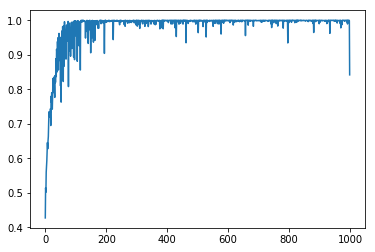

loss graph


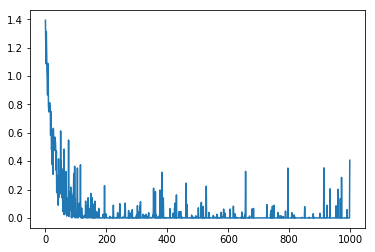

In [8]:
"""first task"""
print("First task started...")
loss_graph=[]
acc_graph=[]
iteration=[]
best_fitness1 = 0.0
gen = 0
first_fitness = []
#pathway 학습 
for gen in range(args.generation_limit):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

    best_fitness1, best_path1, max_fitness1,loss,acc = train_pathnet(model,
                                                         gene,
                                                         cifar_train_loader,
                                                         best_fitness1,
                                                         best_path1,
                                                         gen,optimizer)
    
    first_fitness.append(max_fitness1)
    loss_graph.append(loss)
    acc_graph.append(acc)
    iteration.append(gen)
    print(gen)
print("First task done!! Move to next task")


print("accuracy graph")
plt.plot(iteration,acc_graph)
plt.show()
print("loss graph")
plt.plot(iteration,loss_graph)
plt.show()


In [9]:
test_model(model,cifar_test_loader,best_path1)

Test Accuracy of the model on the test images: 69.36 %


In [10]:
print("Second task started...")
gene = Genetic(args.L, args.M, args.N, args.pop)
model.init(best_path1)
model=model.cuda()
#parameter set
trainable_params = []
params_set = [model.fc1, model.fc2, model.fc3]
for path, params in zip(best_path1, params_set):
    for i, param in enumerate(params):
        if  i in path:
            param.requires_grad = False
        else:
            p = {'params': param.parameters()}
            trainable_params.append(p)

p = {'params': model.final_layers.parameters()}
trainable_params.append(p)
optimizer = optim.Adam(trainable_params, lr=args.lr)

Second task started...


loss : 0.4265, acc : 0.5365
loss : 0.3350, acc : 0.7839
0
loss : 0.3432, acc : 0.7673
loss : 0.2426, acc : 0.8538
1
loss : 0.3756, acc : 0.8217
loss : 0.3511, acc : 0.8512
2
loss : 0.4353, acc : 0.8601
loss : 0.4384, acc : 0.8699
3
loss : 0.2824, acc : 0.8346
loss : 0.2739, acc : 0.8666
4
loss : 0.4593, acc : 0.8695
loss : 0.3478, acc : 0.8773
5
loss : 0.2352, acc : 0.8994
loss : 0.4300, acc : 0.8821
6
loss : 0.2400, acc : 0.8943
loss : 0.2247, acc : 0.8879
7
loss : 0.2488, acc : 0.9081
loss : 0.1585, acc : 0.8979
8
loss : 0.3416, acc : 0.8977
loss : 0.2901, acc : 0.9127
9
loss : 0.3174, acc : 0.9109
loss : 0.2948, acc : 0.9017
10
loss : 0.2153, acc : 0.9101
loss : 0.1820, acc : 0.9098
11
loss : 0.2457, acc : 0.9011
loss : 0.1628, acc : 0.8886
12
loss : 0.3834, acc : 0.9062
loss : 0.3082, acc : 0.9093
13
loss : 0.6019, acc : 0.9076
loss : 0.5201, acc : 0.9044
14
loss : 0.3877, acc : 0.9120
loss : 0.3277, acc : 0.9110
15
loss : 0.4055, acc : 0.8943
loss : 0.3440, acc : 0.9120
16
loss : 

loss : 0.0047, acc : 0.9982
loss : 0.0123, acc : 0.9840
138
loss : 0.0146, acc : 0.9930
loss : 0.1446, acc : 0.9734
139
loss : 0.0347, acc : 0.9979
loss : 0.4178, acc : 0.9460
140
loss : 0.0018, acc : 0.9980
loss : 0.0001, acc : 0.9981
141
loss : 0.0023, acc : 0.9822
loss : 0.0000, acc : 0.9981
142
loss : 0.0186, acc : 0.9718
loss : 0.0023, acc : 0.9922
143
loss : 0.0007, acc : 0.9945
loss : 0.0019, acc : 0.9865
144
loss : 0.0000, acc : 0.9988
loss : 0.0000, acc : 0.9992
145
loss : 0.0001, acc : 0.9965
loss : 0.0000, acc : 0.9989
146
loss : 0.0009, acc : 0.9951
loss : 0.0001, acc : 0.9991
147
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9983
148
loss : 0.1008, acc : 0.9774
loss : 0.0000, acc : 0.9952
149
loss : 0.0003, acc : 0.9992
loss : 0.0000, acc : 0.9991
150
loss : 0.0000, acc : 0.9997
loss : 0.0002, acc : 0.9986
151
loss : 0.0000, acc : 0.9987
loss : 0.0001, acc : 0.9972
152
loss : 0.0000, acc : 0.9994
loss : 0.0001, acc : 0.9988
153
loss : 0.0140, acc : 0.9987
loss : 0.002

loss : 0.0000, acc : 0.9997
274
loss : 0.0001, acc : 0.9992
loss : 0.0004, acc : 0.9993
275
loss : 0.0000, acc : 0.9970
loss : 0.0071, acc : 0.9995
276
loss : 0.0000, acc : 0.9994
loss : 0.0000, acc : 0.9997
277
loss : 0.0000, acc : 0.9996
loss : 0.0124, acc : 0.9928
278
loss : 0.0000, acc : 0.9994
loss : 0.0000, acc : 0.9993
279
loss : 0.0000, acc : 0.9997
loss : 0.0048, acc : 0.9803
280
loss : 0.0000, acc : 0.9989
loss : 0.0005, acc : 0.9942
281
loss : 0.0009, acc : 0.9970
loss : 0.0000, acc : 0.9994
282
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9997
283
loss : 0.0000, acc : 0.9959
loss : 0.0000, acc : 0.9990
284
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9995
285
loss : 0.0001, acc : 0.9967
loss : 0.0000, acc : 0.9991
286
loss : 0.0000, acc : 0.9997
loss : 0.0045, acc : 0.9993
287
loss : 0.0001, acc : 0.9962
loss : 0.0000, acc : 0.9993
288
loss : 0.0003, acc : 0.9989
loss : 0.0000, acc : 0.9996
289
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9998
290
loss : 0

loss : 0.1044, acc : 0.9942
loss : 0.0000, acc : 0.9997
411
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9989
412
loss : 0.0000, acc : 0.9995
loss : 0.0000, acc : 0.9995
413
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9965
414
loss : 0.0003, acc : 0.9951
loss : 0.0000, acc : 0.9995
415
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9995
416
loss : 0.0000, acc : 0.9992
loss : 0.0000, acc : 0.9996
417
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9998
418
loss : 0.0000, acc : 0.9993
loss : 0.0000, acc : 0.9993
419
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9988
420
loss : 0.0023, acc : 0.9992
loss : 0.0000, acc : 0.9992
421
loss : 0.0012, acc : 0.9995
loss : 0.0000, acc : 0.9966
422
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 0.9998
423
loss : 0.0001, acc : 0.9988
loss : 0.0000, acc : 0.9996
424
loss : 0.0000, acc : 0.9994
loss : 0.0000, acc : 0.9992
425
loss : 0.0004, acc : 0.9995
loss : 0.0000, acc : 0.9997
426
loss : 0.0000, acc : 0.9997
loss : 0.000

loss : 0.0000, acc : 1.0000
547
loss : 0.0000, acc : 1.0000
loss : 0.0001, acc : 0.9983
548
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9995
549
loss : 0.0000, acc : 0.9965
loss : 0.0000, acc : 0.9997
550
loss : 0.0000, acc : 0.9996
loss : 0.0001, acc : 0.9978
551
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 0.9997
552
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9996
553
loss : 0.0000, acc : 0.9994
loss : 0.0000, acc : 0.9998
554
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9968
555
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9999
556
loss : 0.0000, acc : 0.9988
loss : 0.0000, acc : 0.9998
557
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9996
558
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9994
559
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9984
560
loss : 0.0000, acc : 0.9996
loss : 0.0002, acc : 0.9936
561
loss : 0.0000, acc : 0.9988
loss : 0.0000, acc : 0.9999
562
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9997
563
loss : 0

loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
684
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
685
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
686
loss : 0.0000, acc : 0.9984
loss : 0.0000, acc : 0.9992
687
loss : 0.0409, acc : 0.9955
loss : 0.0000, acc : 0.9993
688
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 0.9998
689
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9992
690
loss : 0.0000, acc : 0.9988
loss : 0.0000, acc : 0.9992
691
loss : 0.0000, acc : 0.9993
loss : 0.0000, acc : 0.9991
692
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 0.9998
693
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9998
694
loss : 0.0000, acc : 0.9998
loss : 0.0001, acc : 0.9979
695
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9998
696
loss : 0.0000, acc : 0.9988
loss : 0.0028, acc : 0.9945
697
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9993
698
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9999
699
loss : 0.0000, acc : 0.9995
loss : 0.000

loss : 0.0000, acc : 1.0000
820
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
821
loss : 0.0006, acc : 0.9973
loss : 0.0000, acc : 0.9998
822
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9999
823
loss : 0.0000, acc : 0.9946
loss : 0.0000, acc : 0.9979
824
loss : 0.0000, acc : 0.9997
loss : 0.0214, acc : 0.9962
825
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9995
826
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 0.9994
827
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9999
828
loss : 0.0003, acc : 0.9999
loss : 0.0000, acc : 0.9974
829
loss : 0.0000, acc : 0.9984
loss : 0.0006, acc : 0.9999
830
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 0.9999
831
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 0.9994
832
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9981
833
loss : 0.0000, acc : 0.9989
loss : 0.0000, acc : 0.9997
834
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9999
835
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9994
836
loss : 0

loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9999
957
loss : 0.0000, acc : 0.9999
loss : 0.0365, acc : 0.9956
958
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9979
959
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
960
loss : 0.0735, acc : 0.9590
loss : 0.0000, acc : 0.9996
961
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9995
962
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9970
963
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9983
964
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9958
965
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9999
966
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9961
967
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
968
loss : 0.0000, acc : 1.0000
loss : 0.0001, acc : 0.9964
969
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 0.9999
970
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
971
loss : 0.0000, acc : 0.9990
loss : 0.0000, acc : 0.9998
972
loss : 0.0001, acc : 0.9995
loss : 0.000

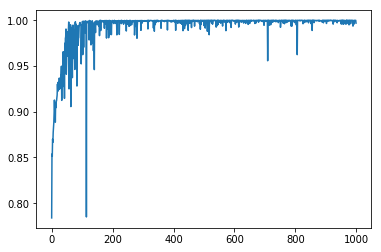

loss graph


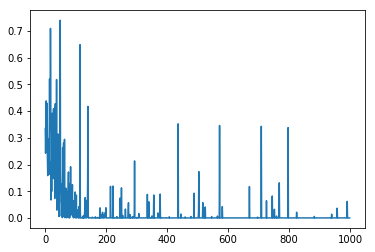

In [11]:
loss_graph=[]
acc_graph=[]
iteration=[]


best_fitness2 = 0.0    
best_path2 = [[None] * args.N] * args.L
gen = 0
second_fitness = []
for gen in range(args.generation_limit):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

    best_fitness2, best_path2, max_fitness2 ,loss,acc= train_pathnet(model,
                                                         gene,
                                                         svhn_train_loader,
                                                         best_fitness2,
                                                         best_path2,
                                                         gen,optimizer)
    second_fitness.append(max_fitness2)
    loss_graph.append(loss)
    acc_graph.append(acc)
    iteration.append(gen)
    print(gen)
print("Second task done!! Goodbye!!")

print("accuracy graph")
plt.plot(iteration,acc_graph)
plt.show()
print("loss graph")
plt.plot(iteration,loss_graph)
plt.show()

In [12]:
test_model(model,svhn_test_loader,best_path2)

Test Accuracy of the model on the test images: 91.3759987707437 %


In [13]:
result=[]
result.append(best_path1)
result.append(best_path2)
np.save("result/cnn_result_cifar_svhn_reduce_sum.npy",result)
torch.save(model.state_dict(), "result/cnn_cifar_svhn_reduce_sum_model.ckpt")

In [14]:
def load_and_test(cifar_test_loader,svhn_test_loader):
    #load data and test
    result=np.load("result/cnn_result_cifar_svhn_reduce_sum.npy")

    model=Net(args)
    model.load_state_dict(torch.load("result/cnn_cifar_svhn_reduce_sum_model.ckpt"))
    model=model.cuda()

    test_model(model,cifar_test_loader,result[0])
    test_model(model,svhn_test_loader,result[1])


In [15]:
from raf_dataset import *
train_data=["D:/emotion_dataset/RAF_Face_Database/basic/train_image_dir.npy","D:/emotion_dataset/RAF_Face_Database/basic/train_label.npy"]
raf_train_dataset=ImageDataset(fnames=train_data,transform=ToTensor())
raf_train_loader=torch.utils.data.DataLoader(dataset=raf_train_dataset,
                                           batch_size=args.batch_size, 
                                           shuffle=True)
test_data=["D:/emotion_dataset/RAF_Face_Database/basic/test_image_dir.npy","D:/emotion_dataset/RAF_Face_Database/basic/test_label.npy"]
raf_test_dataset=ImageDataset(fnames=test_data,transform=ToTensor())
raf_test_loader=torch.utils.data.DataLoader(dataset=raf_test_dataset,
                                           batch_size=args.batch_size, 
                                           shuffle=True)

emotion task started...
loss : 1.6421, acc : 0.3802
loss : 1.6368, acc : 0.3846
loss : 1.4092, acc : 0.3963
loss : 1.0436, acc : 0.5062
loss : 1.1851, acc : 0.5216
loss : 1.2776, acc : 0.4746
loss : 1.2492, acc : 0.4945
loss : 1.3083, acc : 0.4780
loss : 0.9373, acc : 0.6167
loss : 0.8925, acc : 0.6314
loss : 1.4010, acc : 0.4028
loss : 1.1048, acc : 0.5370
loss : 0.9657, acc : 0.5995
loss : 0.9687, acc : 0.6214
loss : 1.0473, acc : 0.5459
loss : 0.7580, acc : 0.6688
loss : 0.8107, acc : 0.7151
loss : 0.7364, acc : 0.7393
loss : 0.7752, acc : 0.7633
loss : 1.0301, acc : 0.6299
loss : 1.1081, acc : 0.5520
loss : 1.0070, acc : 0.6159
loss : 0.9075, acc : 0.6242
loss : 0.7793, acc : 0.6816
loss : 1.1202, acc : 0.5888
loss : 0.7326, acc : 0.7179
loss : 0.9297, acc : 0.6933
loss : 1.0130, acc : 0.6323
loss : 1.0149, acc : 0.6079
loss : 0.8672, acc : 0.6841
loss : 1.2669, acc : 0.6474
loss : 1.2500, acc : 0.6427
loss : 0.7288, acc : 0.7504
loss : 0.9224, acc : 0.6546
loss : 0.7229, acc : 0.7

loss : 0.0255, acc : 0.9818
loss : 0.0018, acc : 0.9995
loss : 0.0679, acc : 0.9619
loss : 0.0012, acc : 0.9985
loss : 0.0049, acc : 0.9892
loss : 0.0004, acc : 0.9996
loss : 0.0058, acc : 0.9986
loss : 0.0004, acc : 0.9999
loss : 0.0052, acc : 0.9987
loss : 0.0021, acc : 1.0000
loss : 0.0007, acc : 1.0000
loss : 0.0006, acc : 0.9997
loss : 0.0426, acc : 0.9731
loss : 0.0038, acc : 0.9971
loss : 0.0015, acc : 0.9998
loss : 0.0158, acc : 0.9894
loss : 0.0016, acc : 0.9995
loss : 0.0003, acc : 1.0000
loss : 0.0004, acc : 1.0000
loss : 0.0043, acc : 0.9986
loss : 0.0005, acc : 0.9996
loss : 0.0023, acc : 0.9837
loss : 0.0002, acc : 0.9932
loss : 0.0010, acc : 0.9995
loss : 0.0027, acc : 0.9999
loss : 0.0066, acc : 0.9991
loss : 0.1040, acc : 0.9913
loss : 0.0191, acc : 0.9985
loss : 0.1691, acc : 0.9115
loss : 0.0370, acc : 0.9709
loss : 0.0011, acc : 0.9961
loss : 0.0012, acc : 0.9994
loss : 0.0003, acc : 0.9987
loss : 0.0010, acc : 0.9999
loss : 0.0258, acc : 0.9760
loss : 0.0135, acc :

loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0374, acc : 0.9830
loss : 0.0001, acc : 0.9998
loss : 0.0005, acc : 1.0000
loss : 0.0001, acc : 1.0000
loss : 0.0021, acc : 0.9993
loss : 0.0001, acc : 1.0000
loss : 0.0801, acc : 0.9936
loss : 0.0020, acc : 0.9970
loss : 0.0106, acc : 0.9941
loss : 0.0001, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0021, acc : 0.9994
loss : 0.0002, acc : 0.9999
loss : 0.0001, acc : 1.0000
loss : 0.0001, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0001, acc : 0.9998
loss : 0.0185, acc : 0.9938
loss : 0.0002, acc : 0.9959
loss : 0.0026, acc : 0.9955
loss : 0.0103, acc : 0.9912
loss : 0.0009, acc : 0.9987
loss : 0.0003, acc : 0.9997
loss : 0.0005, acc : 0.9988
loss : 0.0045, acc : 0.9965
loss : 0.0002, acc : 0.9999
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0001, acc :

loss : 0.0001, acc : 0.9998
loss : 0.0001, acc : 0.9998
loss : 0.0003, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0021, acc : 0.9991
loss : 0.0014, acc : 0.9957
loss : 0.0001, acc : 0.9994
loss : 0.0001, acc : 0.9997
loss : 0.0001, acc : 0.9998
loss : 0.0020, acc : 0.9936
loss : 0.0001, acc : 0.9993
loss : 0.0111, acc : 0.9978
loss : 0.0001, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0001, acc : 1.0000
loss : 0.0001, acc : 0.9999
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0243, acc : 0.9929
loss : 0.0002, acc : 0.9971
loss : 0.0003, acc : 0.9998
loss : 0.0276, acc : 0.9848
loss : 0.0001, acc : 0.9979
loss : 0.0012, acc : 0.9992
loss : 0.0038, acc : 0.9994
loss : 0.0001, acc :

loss : 0.0329, acc : 0.9874
loss : 0.0000, acc : 0.9997
loss : 0.0000, acc : 0.9995
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0009, acc : 1.0000
loss : 0.0001, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0001, acc : 1.0000
loss : 0.0082, acc : 0.9979
loss : 0.0003, acc : 0.9981
loss : 0.0000, acc : 0.9993
loss : 0.0001, acc : 0.9996
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0005, acc : 0.9999
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0002, acc : 1.0000
loss : 0.0829, acc : 0.9990
loss : 0.0041, acc : 0.9989
loss : 0.0000, acc : 0.9987
loss : 0.0001, acc :

loss : 0.0001, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0032, acc : 0.9935
loss : 0.0116, acc : 0.9888
loss : 0.0000, acc : 0.9981
loss : 0.0014, acc : 0.9965
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9991
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0002, acc : 0.9995
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9992
loss : 0.0002, acc : 0.9985
loss : 0.0016, acc : 0.9974
loss : 0.0007, acc : 0.9973
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 1.0000
loss : 0.0006, acc : 0.9985
loss : 0.0002, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0052, acc : 0.9980
loss : 0.0002, acc : 0.9993
loss : 0.0003, acc :

loss : 0.0000, acc : 1.0000
loss : 0.0010, acc : 0.9965
loss : 0.1839, acc : 0.9867
loss : 0.0008, acc : 0.9953
loss : 0.0042, acc : 0.9993
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 0.9996
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9994
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 0.9995
loss : 0.0012, acc : 0.9998
loss : 0.0040, acc : 0.9895
loss : 0.0000, acc : 0.9997
loss : 0.0009, acc : 0.9999
loss : 0.0001, acc : 0.9988
loss : 0.0000, acc : 0.9998
loss : 0.0004, acc : 1.0000
loss : 0.0000, acc : 0.9999
loss : 0.0986, acc : 0.9958
loss : 0.0000, acc : 0.9993
loss : 0.0001, acc : 0.9956
loss : 0.0005, acc : 0.9979
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9998
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 0.9999
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.0000, acc : 1.0000
loss : 0.2040, acc : 0.9357
loss : 0.0003, acc : 0.9983
loss : 0.0000, acc :

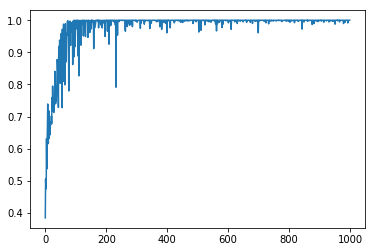

loss graph


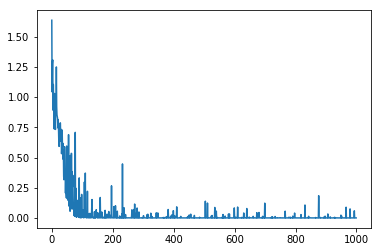

In [16]:
print("emotion task started...")
gene = Genetic(args.L, args.M, args.N, args.pop)
model.init(best_path2)
model.cuda()
#parameter set
trainable_params = []
params_set = [model.fc1, model.fc2, model.fc3]
for path, params in zip(best_path2, params_set):
    for i, param in enumerate(params):
        if  i in path:
            param.requires_grad = False
        else:
            p = {'params': param.parameters()}
            trainable_params.append(p)
            
p = {'params': model.final_layers.parameters()}
trainable_params.append(p)
optimizer = optim.Adam(trainable_params, lr=args.lr)


loss_graph=[]
acc_graph=[]
iteration=[]


best_fitness3 = 0.0    
best_path3 = [[None] * args.N] * args.L
gen = 0
second_fitness = []
for gen in range(args.generation_limit):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

    best_fitness3, best_path3, max_fitness3 ,loss,acc= train_pathnet(model,
                                                         gene,
                                                         raf_train_loader,
                                                         best_fitness3,
                                                         best_path3,
                                                         gen,optimizer)
    second_fitness.append(max_fitness3)
    loss_graph.append(loss)
    acc_graph.append(acc)
    iteration.append(gen)
    
print("emotion task done!! Goodbye!!")

print("accuracy graph")
plt.plot(iteration,acc_graph)
plt.show()
print("loss graph")
plt.plot(iteration,loss_graph)
plt.show()

In [17]:
test_model(model,raf_test_loader,best_path3)

Test Accuracy of the model on the test images: 71.74054758800521 %


In [18]:
result=[]
result.append(best_path3)
np.save("result/cnn_meta_tranfer_emotion.npy",result)
torch.save(model.state_dict(), "result/cnn_meta_tranfer_emotion.ckpt")